# Find Camera Parameter

### Import Lib

In [1]:
import matplotlib.pyplot as plt

import cv2, copy, json
import numpy as np

### Find Intrinsic Parmeters

In [2]:
chessboard_img = cv2.imread('./img_folder/calibration_img.jpg')
Is_intrinsic_calibration = False

In [3]:
resized_chessboard_img = cv2.resize(chessboard_img, dsize = (640, 480), interpolation = cv2.INTER_AREA)
resized_chessboard_gray_img = cv2.cvtColor(resized_chessboard_img, cv2.COLOR_BGR2GRAY)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# chessboard vertical & horizontal line
wc, hc = 7, 7
objp = np.zeros((wc * hc, 3), np.float32)
objp[:, :2] = np.mgrid[0:wc, 0:hc].T.reshape(-1, 2)

objpoints = []
imgpoints = []

ret, corners = cv2.findChessboardCorners(resized_chessboard_gray_img, (wc, hc), None)

if ret == True:
    objpoints.append(objp)

    corners2 = cv2.cornerSubPix(resized_chessboard_gray_img, corners, (10, 10), (-1, -1), criteria)
    imgpoints.append(corners2)
    resized_chessboard_drow_corners_img = copy.deepcopy(resized_chessboard_img)
    resized_chessboard_drow_corners_img = cv2.drawChessboardCorners(resized_chessboard_drow_corners_img, (wc, hc), corners2, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, resized_chessboard_gray_img.shape[::-1], None, None)  ## 왜곡 펴기
    h, w = resized_chessboard_gray_img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1)
    undistorted_resized_chessboard_img = cv2.undistort(resized_chessboard_img, mtx, dist, None, newcameramtx)

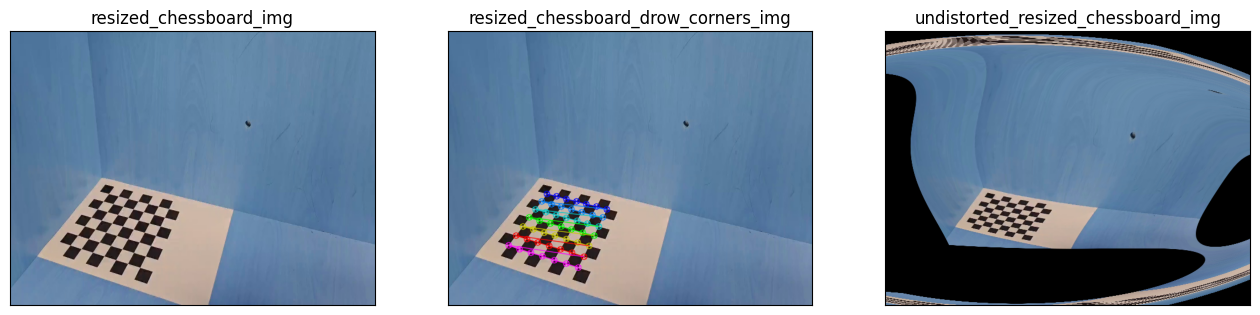

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(16,9))
ax[0].set_title('resized_chessboard_img')
ax[0].imshow(resized_chessboard_img)
ax[1].set_title('resized_chessboard_drow_corners_img')
ax[1].imshow(resized_chessboard_drow_corners_img)
ax[2].set_title('undistorted_resized_chessboard_img')
ax[2].imshow(undistorted_resized_chessboard_img)

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [5]:
if not Is_intrinsic_calibration:
    newcameramtx = np.array([[1.0, 0.0, 320.0],[0.0, 1.0, 240.0],[0.0, 0.0, 1.0]])

print("-----Intrinsic camera paramter-----")
print(newcameramtx)

-----Intrinsic camera paramter-----
[[  1.   0. 320.]
 [  0.   1. 240.]
 [  0.   0.   1.]]


### Find Extrinsic Paramter

In [6]:
test_image = copy.deepcopy(resized_chessboard_img)

In [7]:
# Find image (u, v) - 3D world (x, y, z) 
uv_list = []

def mouse_callback(event, u, v, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(test_image, (u, v), 6, (0, 0, 255), 3)
        uv_list.append([u, v])
        cv2.imshow("test_image", test_image)
        

cv2.imshow("test_image", test_image)
cv2.setMouseCallback("test_image", mouse_callback)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
uv_list = np.array(uv_list, dtype="double")

xyz_list = np.array([
    [0.0, 0.0, 0.001],
    [7.0, 0.0, 0.0],
    [0.0, 7.0, 0.002],
    [7.0, 7.0, 0.003]
], dtype="double")

print("uv point")
print(uv_list)
print("xyz point")
print(xyz_list)

uv point
[[167. 270.]
 [283. 298.]
 [ 88. 368.]
 [228. 414.]]
xyz point
[[0.e+00 0.e+00 1.e-03]
 [7.e+00 0.e+00 0.e+00]
 [0.e+00 7.e+00 2.e-03]
 [7.e+00 7.e+00 3.e-03]]


In [10]:
dist_coeffs = np.zeros((4,1))

success, rotation_vector, translation_vector = cv2.solvePnP(xyz_list, uv_list, np.array(newcameramtx), dist_coeffs, flags=0)
rotation_matrix, _ = cv2.Rodrigues(rotation_vector)

In [11]:
print("-----Extrinsic camera paramter-----")
print("translation_vector")
print(translation_vector)
print("rotation_matrix")
print(rotation_matrix)

-----Extrinsic camera paramter-----
translation_vector
[[-8.91927265]
 [ 1.06988852]
 [ 0.05806952]]
rotation_matrix
[[ 8.89702024e-01 -4.56539319e-01 -1.46955870e-03]
 [ 4.56540265e-01  8.89702675e-01  3.70441456e-04]
 [ 1.13834922e-03 -1.00049523e-03  9.99998852e-01]]


#### Save Camera Parameter

In [12]:
Extrinsic_parameters = {'translation_vector' : translation_vector.tolist(),
                        'rotation_matrix' : rotation_matrix.tolist()}

camera_parameter = {
    'Intrinsic parameters' : newcameramtx.tolist(),
    'Extrinsic parameters' : Extrinsic_parameters
}

with open('./save_folder/camera_parameter_1103.json', 'w') as f:
    json.dump(camera_parameter, f)
